# Evaluate Performance of Various Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 15, 
      'axes.titlesize': 15,
      'legend.fontsize': 15,
      'xtick.labelsize': 12
     }
#       'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('whitegrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

Functions:
1. Read csv from runs.
2. Plot monthly west and east temperature and comfortable range. (Visualization of violations)
3. Calculate the PUE of various models on various cities. (Energy Performance)
4. Calculate violations percentage of various models on various cities. (Temperature Constraints)

In [3]:
cities = ['SF', 'Golden', 'Chicago', 'Sterling']

In [4]:
# read PPO result
ppo_data_frame = {}
for city in cities:
    folder = 'runs/{}_23.5_0.95_1.5_ppo'.format(city)
    episode_index = 15
    file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
    ppo_data_frame[city] = pd.read_csv(file)

In [5]:
baseline_data_frame = {}
for city in cities:
    folder = 'runs/{}_23.5_1.5_1.0_0.5_pid'.format(city)
    episode_index = 0
    file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
    baseline_data_frame[city] = pd.read_csv(file)

In [6]:
def calculate_daily_pue(data_frame):
    ite_power = data_frame['ite_power'].values
    hvac_power = data_frame['hvac_power'].values
    total_power = ite_power + hvac_power
    total_power = np.sum(np.reshape(total_power, (-1, 96)), axis=-1)
    ite_power = np.sum(np.reshape(ite_power, (-1, 96)), axis=-1)
    pue = total_power / ite_power
    return pue

In [7]:
def calculate_daily_mean_total_power(data_frame):
    ite_power = data_frame['ite_power'].values
    hvac_power = data_frame['hvac_power'].values
    total_power = ite_power + hvac_power
    total_power = np.mean(np.reshape(total_power, (-1, 96)), axis=-1)
    pue = total_power / 1e6
    return pue

In [8]:
def calculate_daily_violation_rate(data_frame, temperature_center=23.5, temperature_tolerance=1.5):
    west_temperature = data_frame['west_temperature'].values
    east_temperature = data_frame['east_temperature'].values
    upper_bound = temperature_center + temperature_tolerance
    lower_bound = temperature_center - temperature_tolerance
    west_temp_violation = np.logical_or(west_temperature > upper_bound, 
                                        west_temperature < lower_bound)
    east_temp_violations = np.logical_or(east_temperature > upper_bound,
                                        east_temperature < lower_bound)
    total_violations = np.logical_or(west_temp_violation, east_temp_violations)
    total_violations = np.reshape(total_violations, (-1, 96))
    violation_rate = np.sum(total_violations, axis=-1) / 96
    return violation_rate

In [9]:
def plot_temperature(data_frame, city, temperature_center=23.5, temperature_tolerance=1.5, 
                     start_index=0, num_days=30):
    end_index = start_index + num_days
    two_month = data_frame[start_index*96:end_index*96]
    x = np.linspace(0, num_days, num_days * 96)
    west_temperature = two_month['west_temperature'].values
    east_temperature = two_month['east_temperature'].values
    plt.figure(figsize=(15, 8))
    plt.plot(x, west_temperature, label='west_temperature')
    plt.plot(x, east_temperature, label='east_temperature')
    plt.hlines([temperature_center + temperature_tolerance, 
                temperature_center - temperature_tolerance],
              x[0], x[-1], colors='r', linestyles='dashed', label='comfortable zone')
    plt.xlabel('Day Index')
    plt.ylabel('Temperature ($^\circ$C)')
    plt.title('City = {}'.format(city))
    plt.legend()

In [10]:
def get_log_dir(city, mpc_horizon, num_on_policy_rollouts, training_epochs, dagger=False):
    if dagger:
        log_dir = 'runs/{}_{}_{}_{}_{}_{}_{}_{}_{}_model_based'.format(city, 23.5, 1.5,
                                                                       20, mpc_horizon,
                                                                       8192,
                                                                       num_on_policy_rollouts,
                                                                       training_epochs,
                                                                       dagger)
    else:
        log_dir = 'runs/{}_{}_{}_{}_{}_{}_{}_{}_model_based'.format(city, 23.5, 1.5,
                                                                       20, mpc_horizon,
                                                                       8192,
                                                                       num_on_policy_rollouts,
                                                                       training_epochs)
    return log_dir

### Evaluate training epoches

In [11]:
# Create a new data frame containing training epochs, city, PUE and violation rate
def create_training_epochs_comparison_data_frame():
    training_epochs_lst = [30, 60, 90, 120]
    result = {'Training Epochs': [], 'City': [], 'Daily PUE': [], 'Daily Violation Rate': [], 'Daily Average Power (MW)': []}
    for training_epochs in training_epochs_lst:
        for city in cities:
            data_frame = pd.read_csv(get_log_dir(city, 5, 10, training_epochs) + '/episode-1.csv')
            pue = calculate_daily_pue(data_frame)
            violation_rate = calculate_daily_violation_rate(data_frame)
            result['Training Epochs'].extend([training_epochs] * pue.shape[0])
            result['City'].extend([city] * pue.shape[0])
            result['Daily PUE'].extend(pue.tolist())
            result['Daily Violation Rate'].extend(violation_rate.tolist())
            daily_average_power = calculate_daily_mean_total_power(data_frame)
            result['Daily Average Power (MW)'].extend(daily_average_power.tolist())
    result = pd.DataFrame(result)
    return result

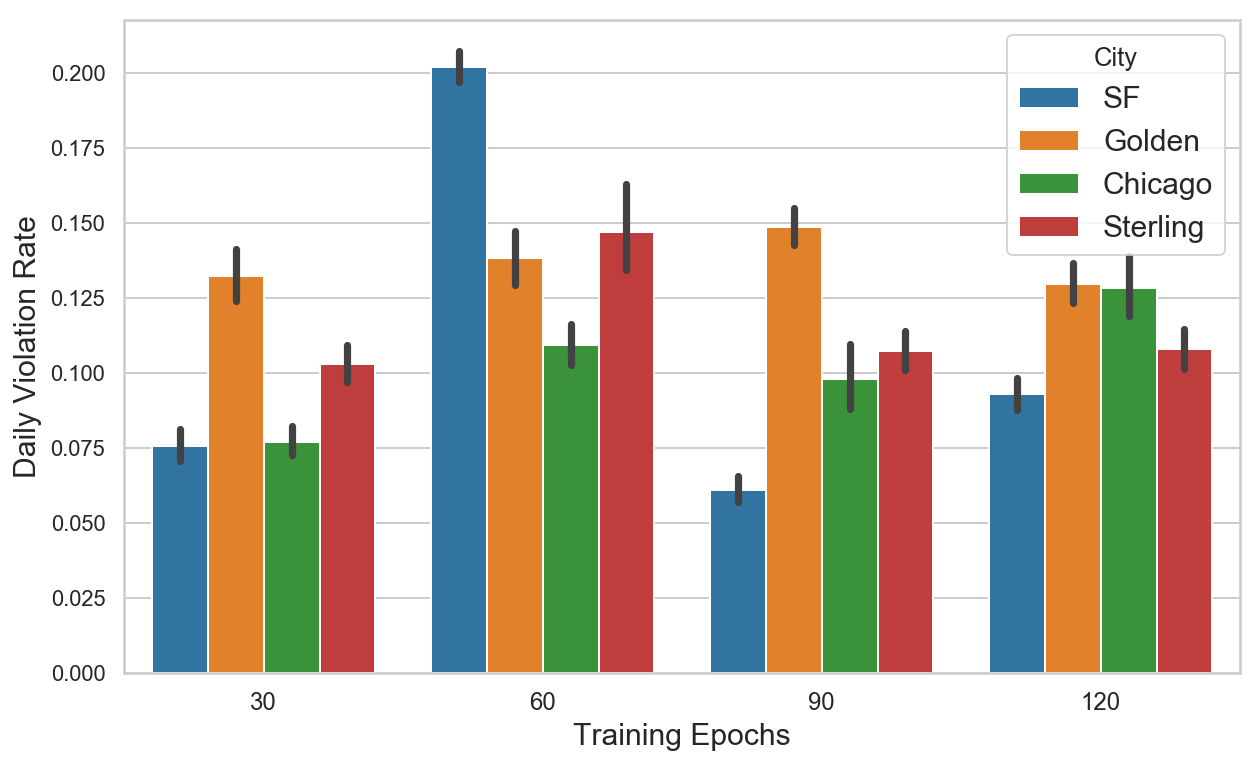

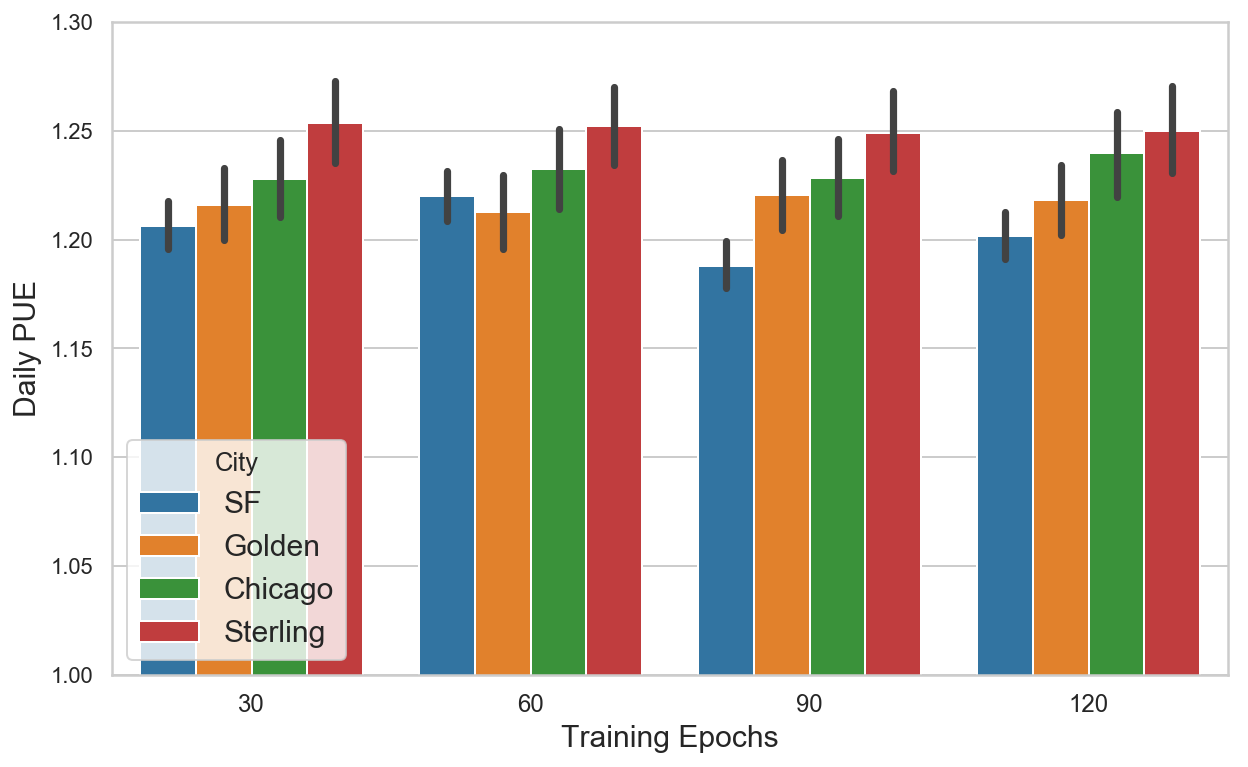

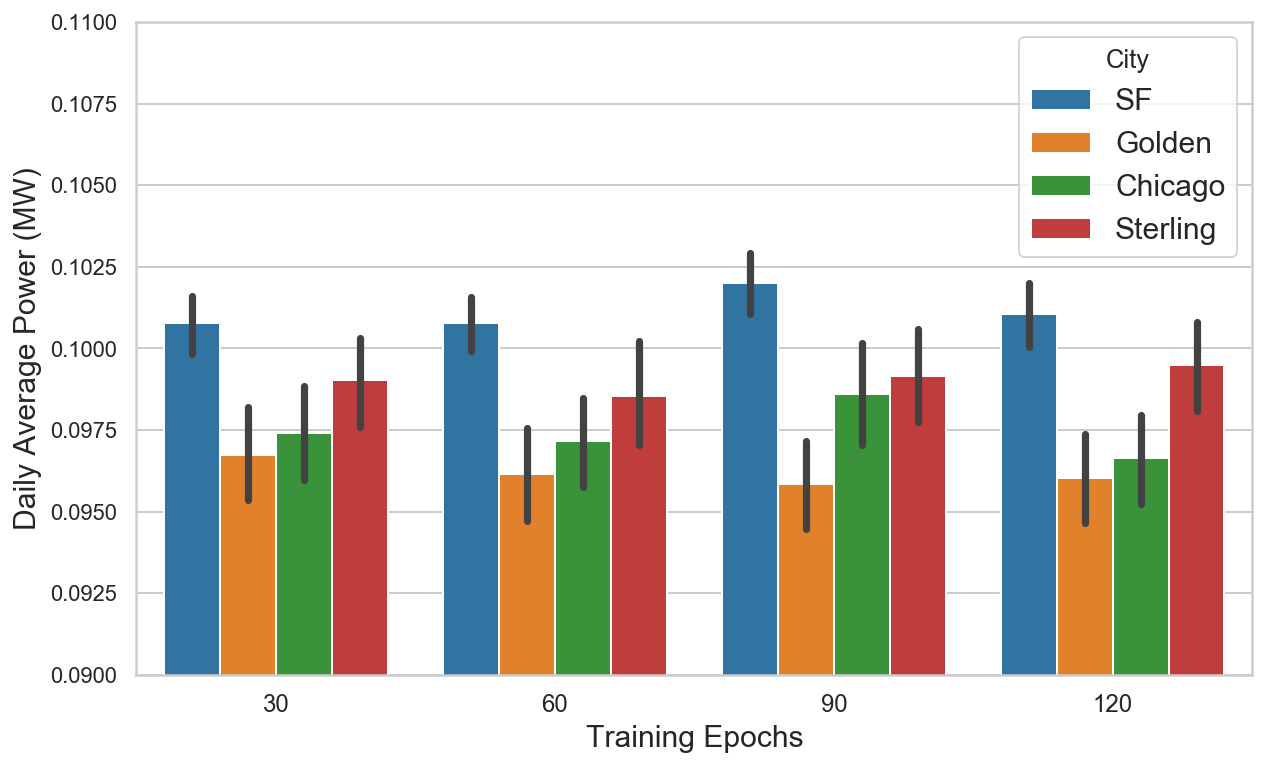

In [12]:
training_epochs_comparison_data_frame = create_training_epochs_comparison_data_frame()
ax = sns.barplot(x="Training Epochs", y="Daily Violation Rate", hue="City", data=training_epochs_comparison_data_frame)
plt.show()
ax = sns.barplot(x="Training Epochs", y="Daily PUE", hue="City", data=training_epochs_comparison_data_frame)
ax.set_ylim(1.0, 1.3)
plt.show()
ax = sns.barplot(x="Training Epochs", y="Daily Average Power (MW)", hue="City", data=training_epochs_comparison_data_frame)
ax.set_ylim(0.09, 0.11)
plt.show()

### Evaluate MPC horizon

In [13]:
# Create a new data frame containing mpc_horizon, city, PUE and violation rate
def create_mpc_horizon_comparison_data_frame():
    mpc_horizon_lst = [5, 10, 15, 20]
    result = {'MPC Horizon': [], 'City': [], 'Daily PUE': [], 'Daily Violation Rate': [], 'Daily Average Power (MW)': []}
    for mpc_horizon in mpc_horizon_lst:
        for city in cities:
            data_frame = pd.read_csv(get_log_dir(city, mpc_horizon, 10, 100) + '/episode-1.csv')
            pue = calculate_daily_pue(data_frame)
            violation_rate = calculate_daily_violation_rate(data_frame)
            result['MPC Horizon'].extend([mpc_horizon] * pue.shape[0])
            result['City'].extend([city] * pue.shape[0])
            result['Daily PUE'].extend(pue.tolist())
            result['Daily Violation Rate'].extend(violation_rate.tolist())
            daily_average_power = calculate_daily_mean_total_power(data_frame)
            result['Daily Average Power (MW)'].extend(daily_average_power.tolist())
    result = pd.DataFrame(result)
    return result

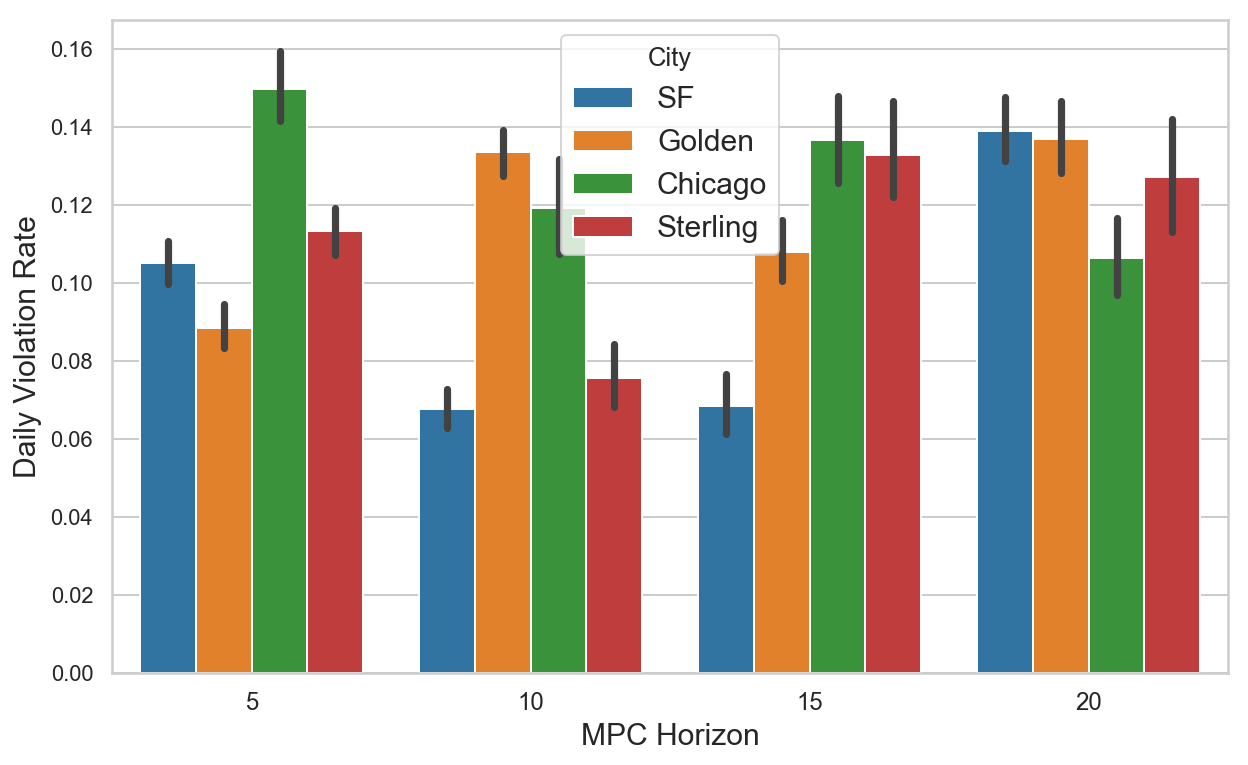

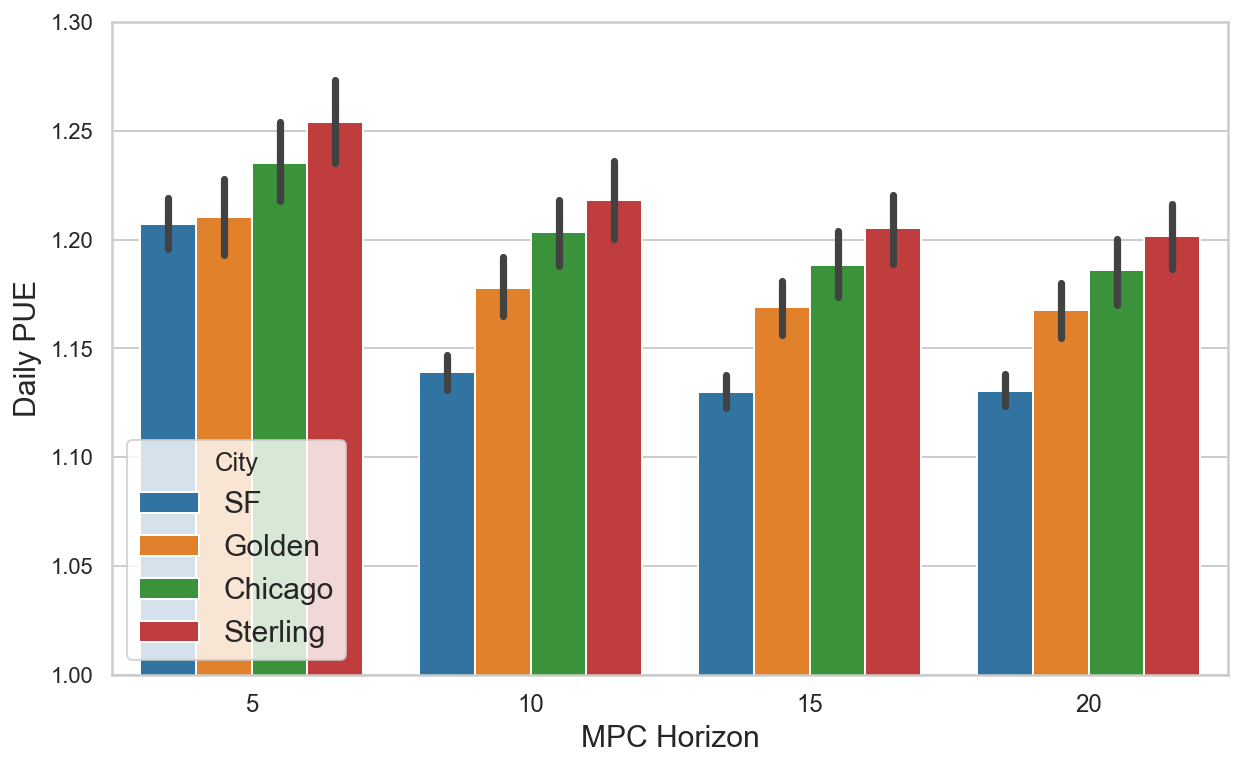

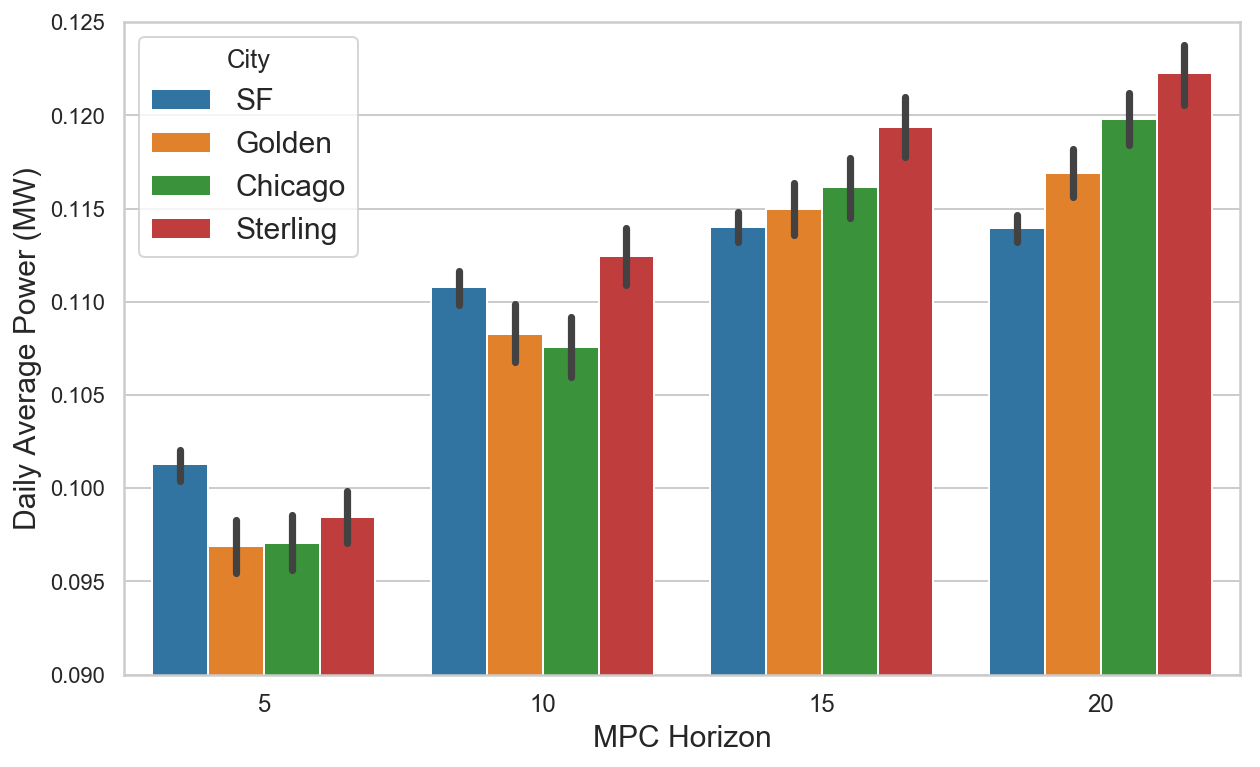

In [14]:
mpc_comparison_data_frame = create_mpc_horizon_comparison_data_frame()
ax = sns.barplot(x="MPC Horizon", y="Daily Violation Rate", hue="City", data=mpc_comparison_data_frame)
plt.show()
ax = sns.barplot(x="MPC Horizon", y="Daily PUE", hue="City", data=mpc_comparison_data_frame)
ax.set_ylim(1.0, 1.3)
plt.show()
ax = sns.barplot(x="MPC Horizon", y="Daily Average Power (MW)", hue="City", data=mpc_comparison_data_frame)
ax.set_ylim(0.09, 0.125)
plt.show()

### Data Aggregation Frequency

In [15]:
# Create a new data frame containing mpc_horizon, city, PUE and violation rate
metric = 'On Policy Frequency (Days)'
def create_on_policy_frequency_comparison_data_frame():
    on_policy_frequency_lst = [3, 7, 10, 14]
    result = {metric: [], 'City': [], 'Daily PUE': [], 'Daily Violation Rate': [], 'Daily Average Power (MW)': []}
    for on_policy_frequency in on_policy_frequency_lst:
        for city in cities:
            data_frame = pd.read_csv(get_log_dir(city, 5, on_policy_frequency, 100) + '/episode-1.csv')
            pue = calculate_daily_pue(data_frame)
            violation_rate = calculate_daily_violation_rate(data_frame)
            result[metric].extend([on_policy_frequency] * pue.shape[0])
            result['City'].extend([city] * pue.shape[0])
            result['Daily PUE'].extend(pue.tolist())
            result['Daily Violation Rate'].extend(violation_rate.tolist())
            daily_average_power = calculate_daily_mean_total_power(data_frame)
            result['Daily Average Power (MW)'].extend(daily_average_power.tolist())
    result = pd.DataFrame(result)
    return result

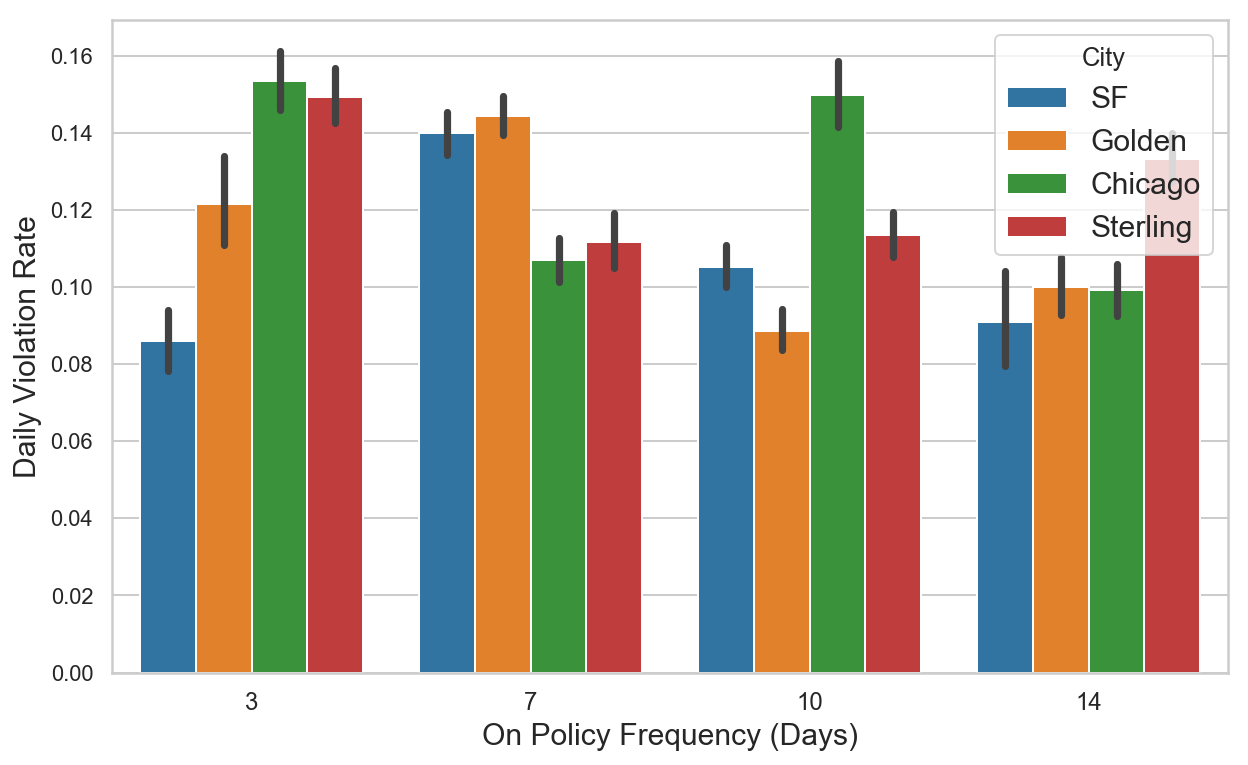

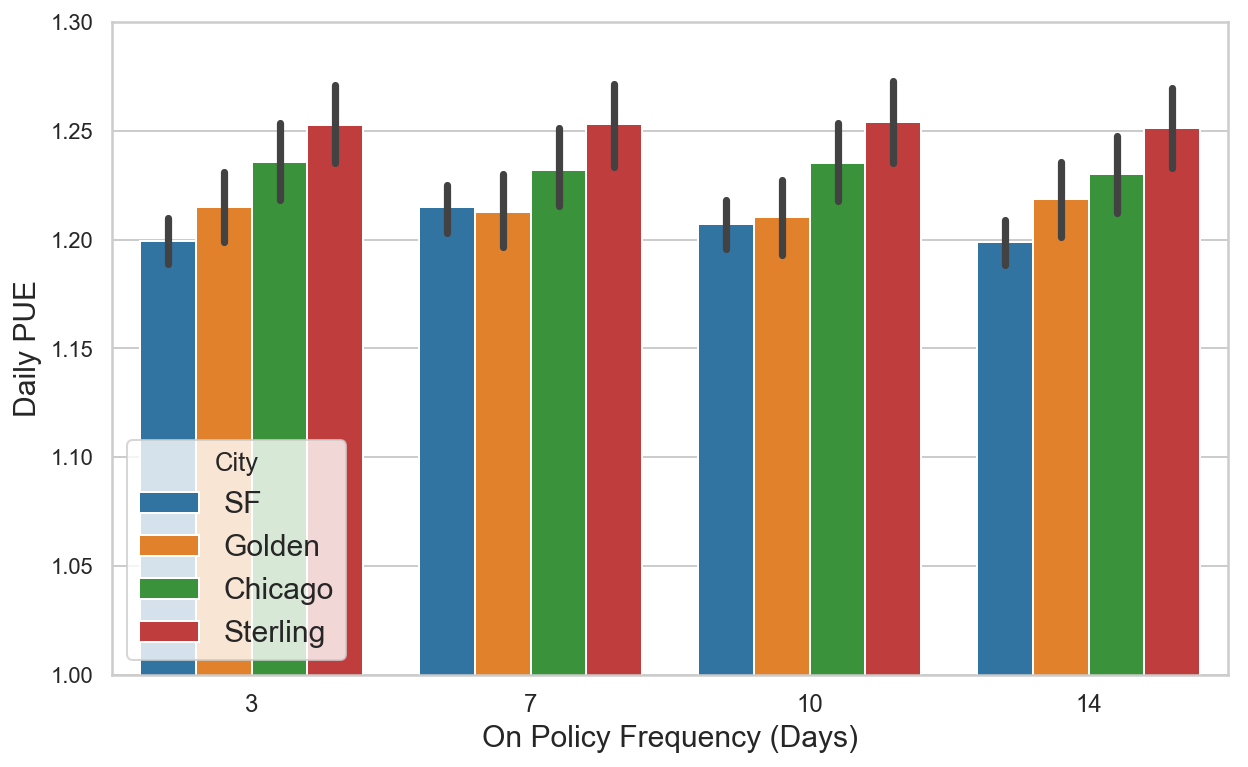

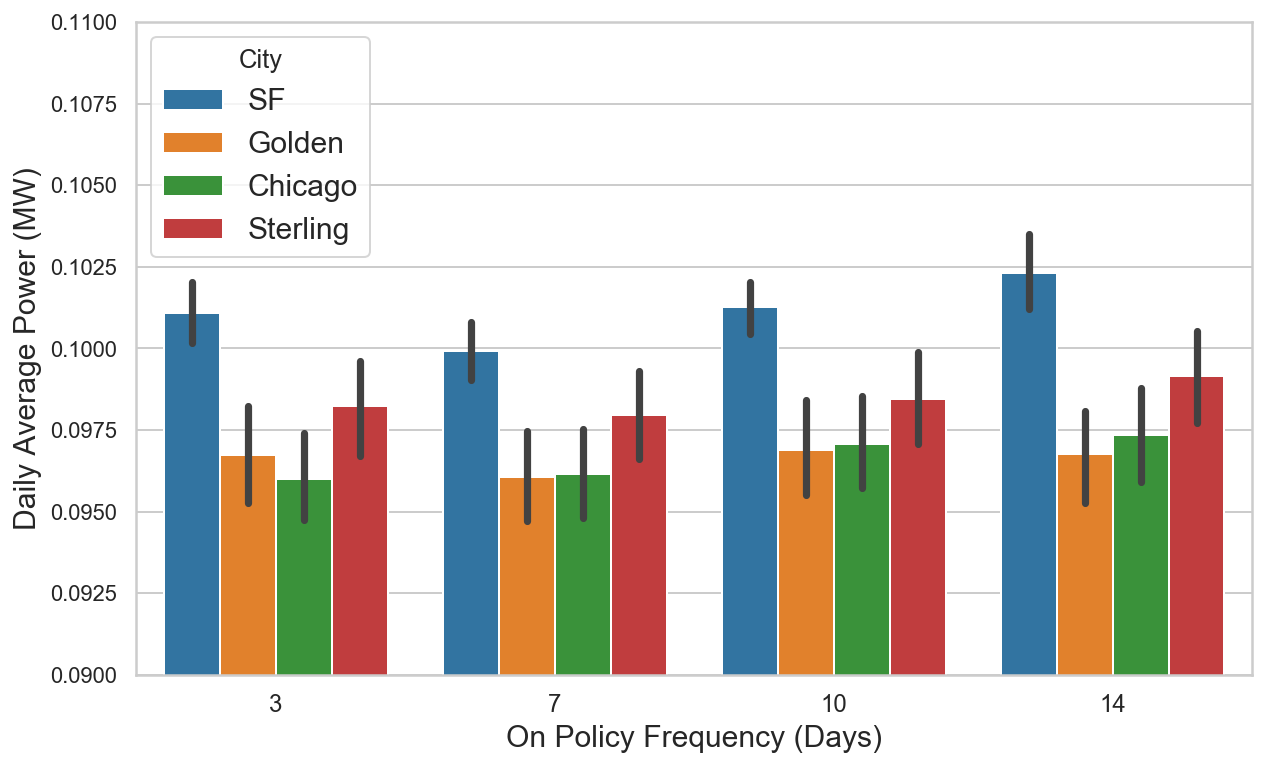

In [16]:
on_policy_frequency_data_frame = create_on_policy_frequency_comparison_data_frame()
ax = sns.barplot(x=metric, y="Daily Violation Rate", hue="City", data=on_policy_frequency_data_frame)
plt.show()
ax = sns.barplot(x=metric, y="Daily PUE", hue="City", data=on_policy_frequency_data_frame)
ax.set_ylim(1.0, 1.3)
plt.show()
ax = sns.barplot(x=metric, y="Daily Average Power (MW)", hue="City", data=on_policy_frequency_data_frame)
ax.set_ylim(0.09, 0.11)
plt.show()

### Compare MPC vs. Imitation Learning

In [17]:
metric = 'Policy'
def create_policy_comparison_data_frame():
    metric_lst = ['MPC', 'Neural Network']
    result = {metric: [], 'City': [], 'Daily PUE': [], 'Daily Violation Rate': [], 'Daily Average Power (MW)': []}
    for policy in metric_lst:
        for city in cities:
            data_frame = pd.read_csv(get_log_dir(city, 5, 10, 100, policy=='Neural Network') + '/episode-1.csv')
            pue = calculate_daily_pue(data_frame)
            violation_rate = calculate_daily_violation_rate(data_frame)
            result[metric].extend([policy] * pue.shape[0])
            result['City'].extend([city] * pue.shape[0])
            result['Daily PUE'].extend(pue.tolist())
            result['Daily Violation Rate'].extend(violation_rate.tolist())
            daily_average_power = calculate_daily_mean_total_power(data_frame)
            result['Daily Average Power (MW)'].extend(daily_average_power.tolist())
    result = pd.DataFrame(result)
    return result

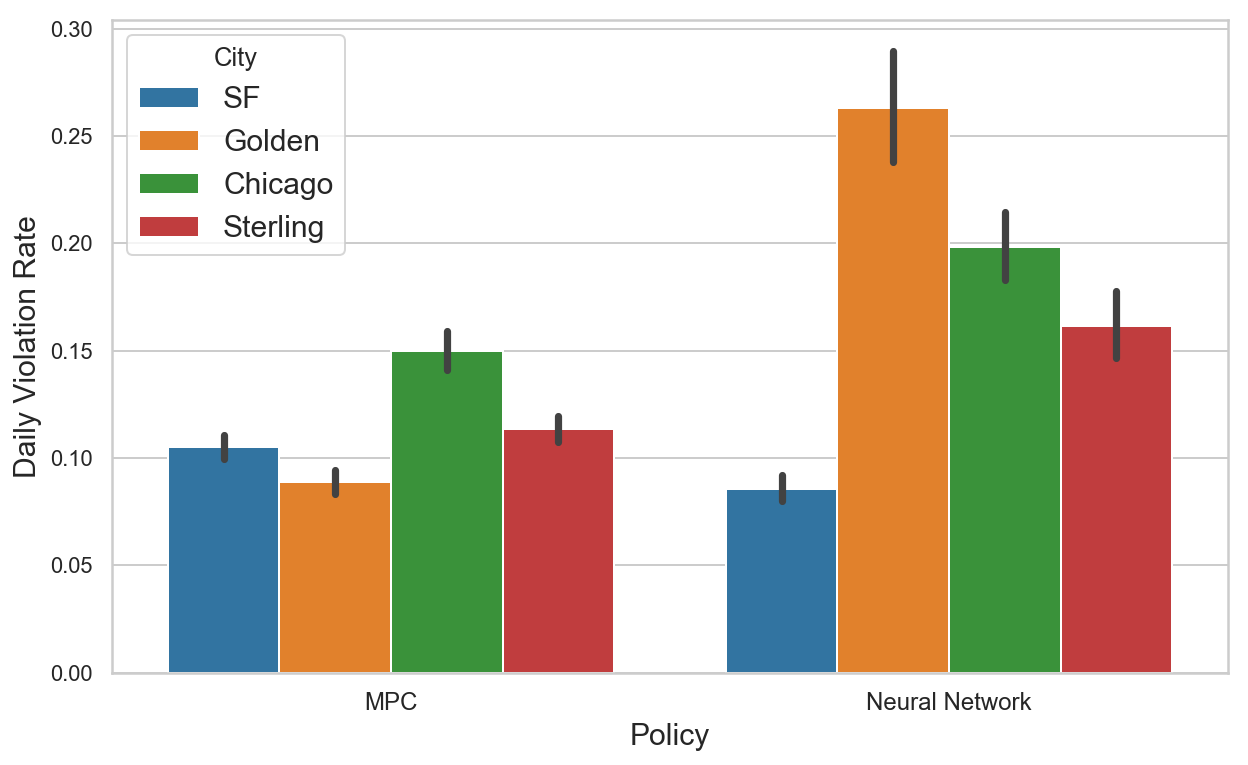

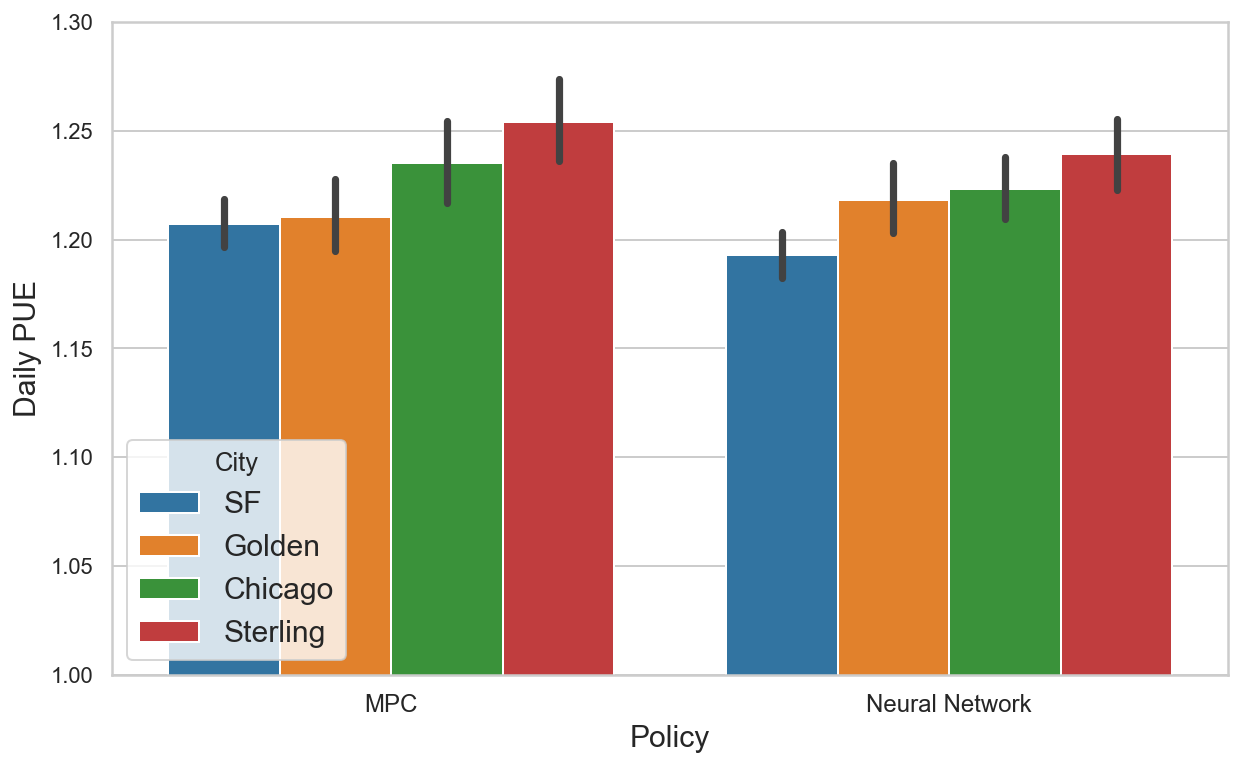

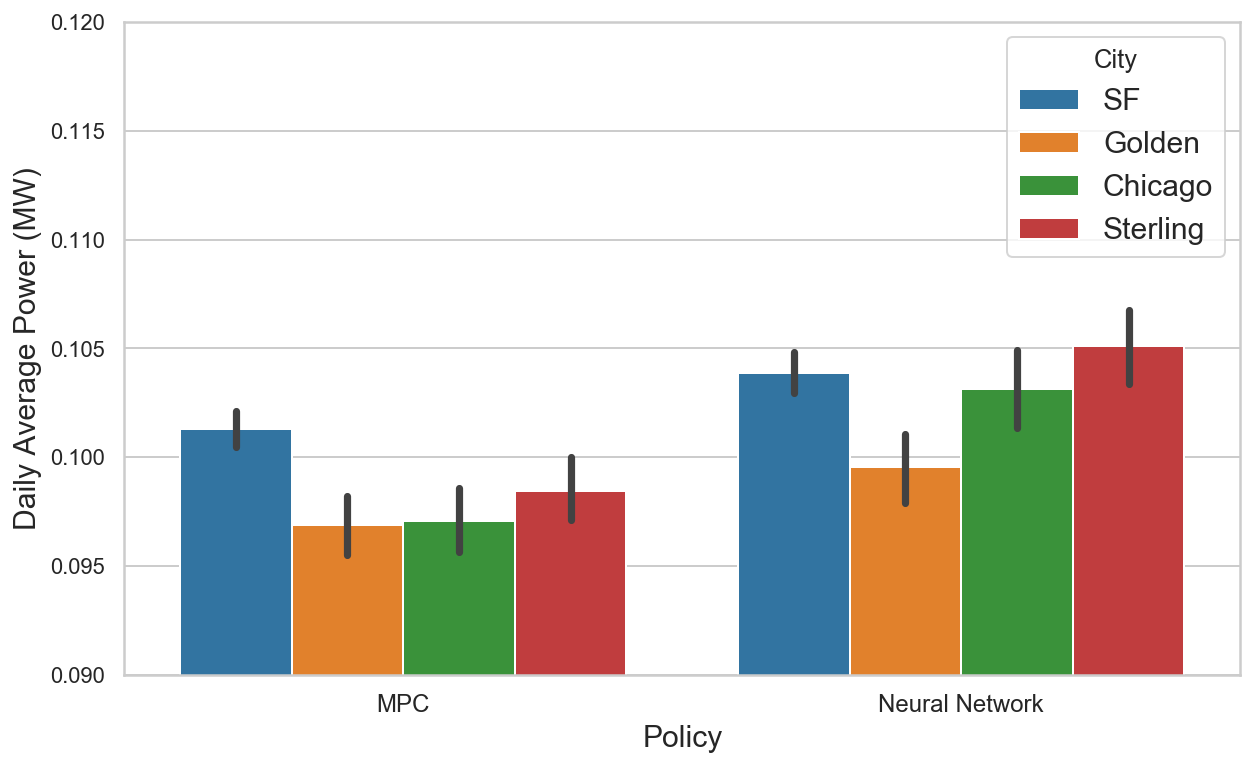

In [18]:
policy_comparison_data_frame = create_policy_comparison_data_frame()
ax = sns.barplot(x=metric, y="Daily Violation Rate", hue="City", data=policy_comparison_data_frame)
plt.show()
ax = sns.barplot(x=metric, y="Daily PUE", hue="City", data=policy_comparison_data_frame)
ax.set_ylim(1.0, 1.3)
plt.show()
ax = sns.barplot(x=metric, y="Daily Average Power (MW)", hue="City", data=policy_comparison_data_frame)
ax.set_ylim(0.09, 0.12)
plt.show()

### Three figures show baseline, PPO and Model-based on one month HVAC control

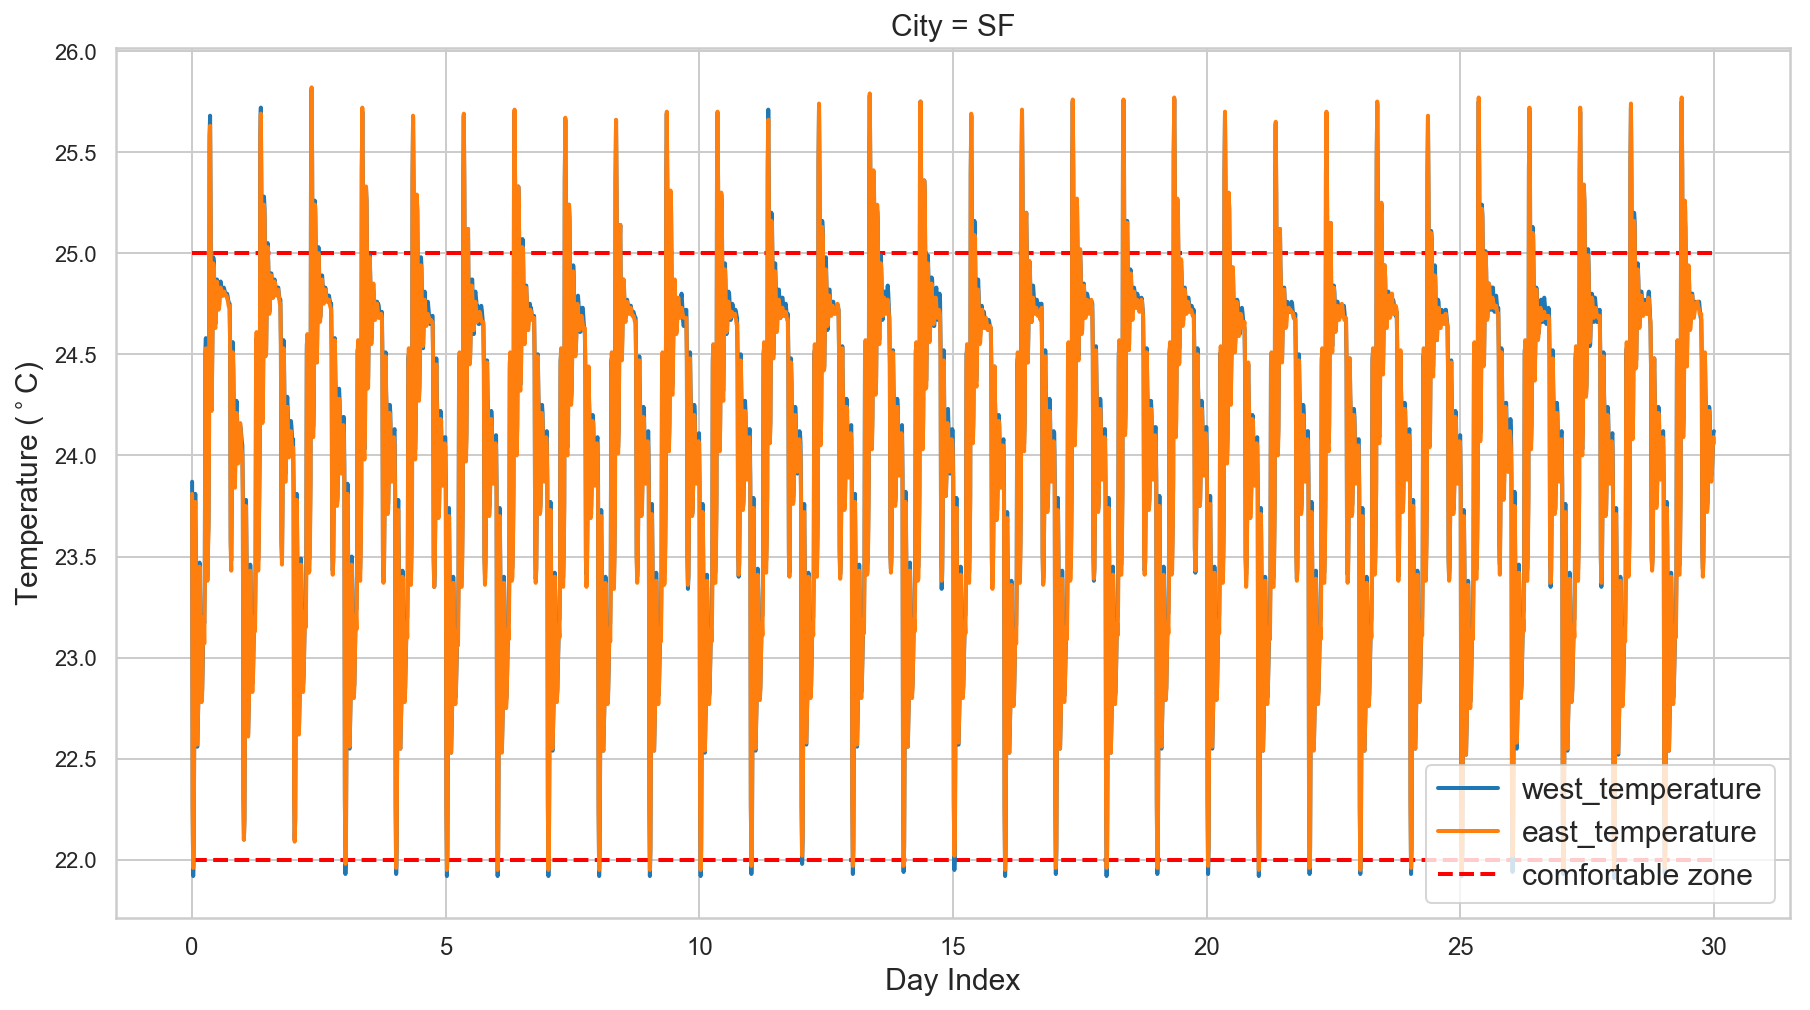

In [19]:
plot_temperature(baseline_data_frame['SF'], city='SF', start_index=90)

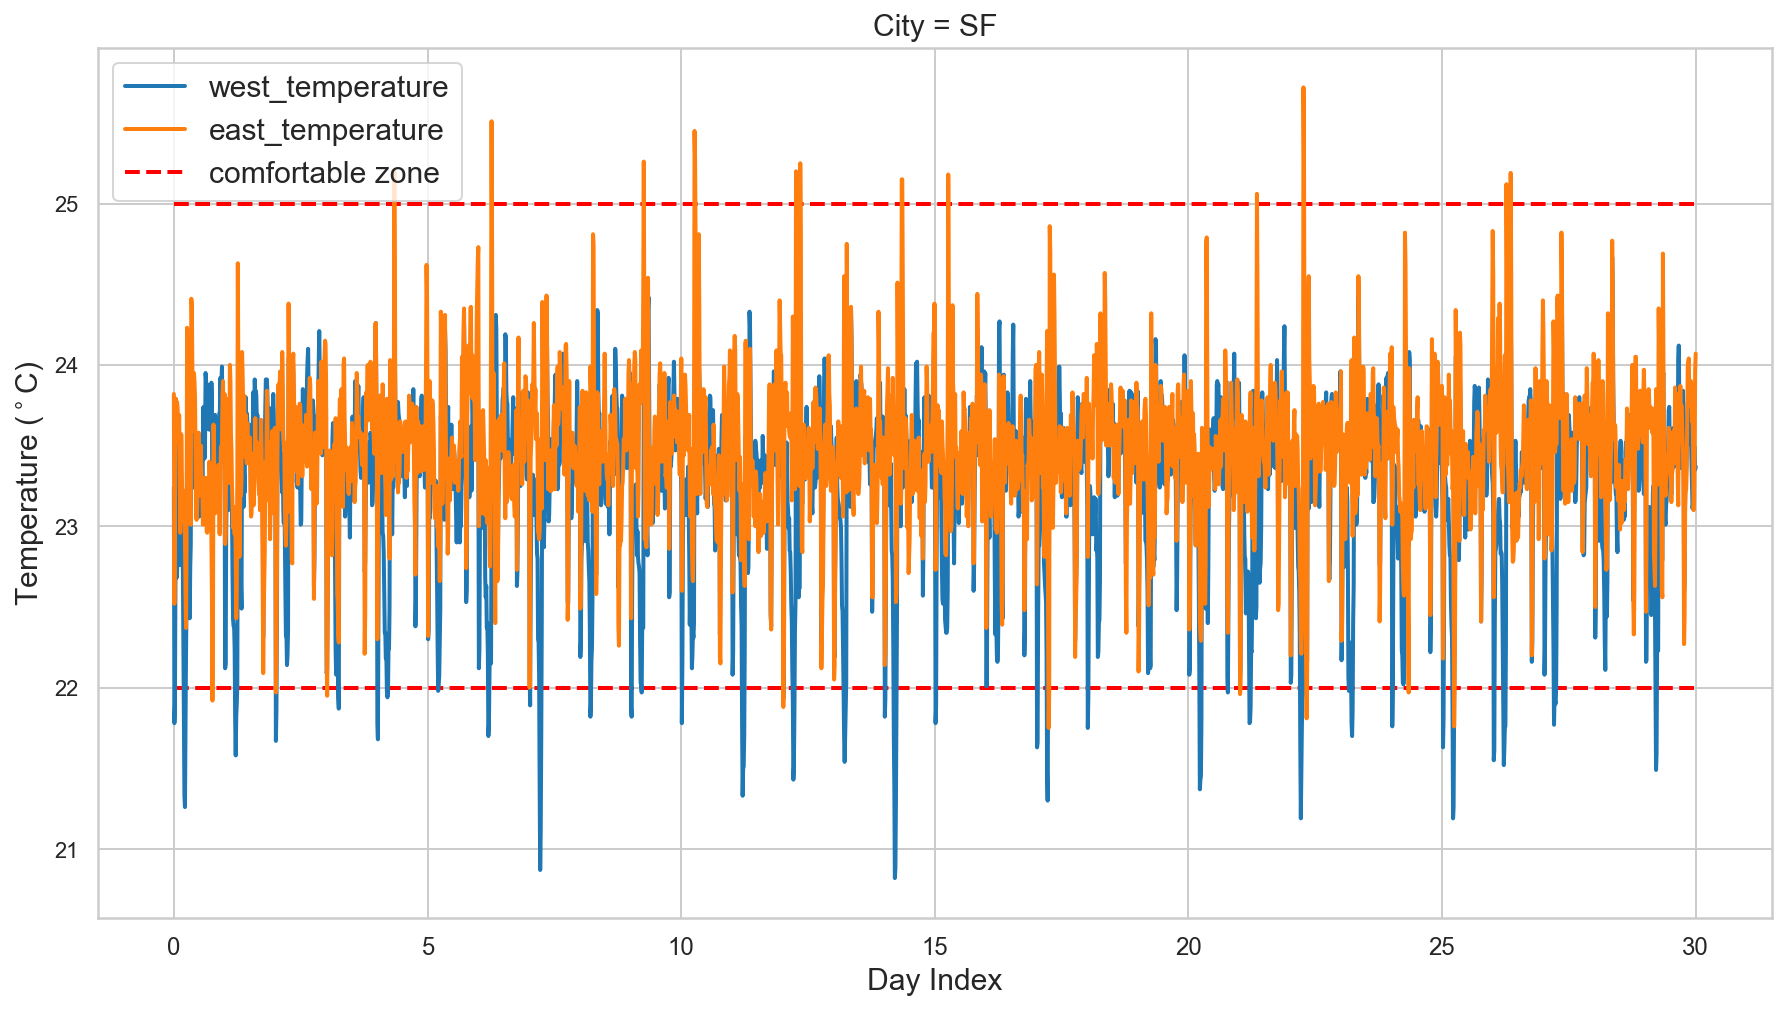

In [20]:
plot_temperature(ppo_data_frame['SF'], city='SF', start_index=90)

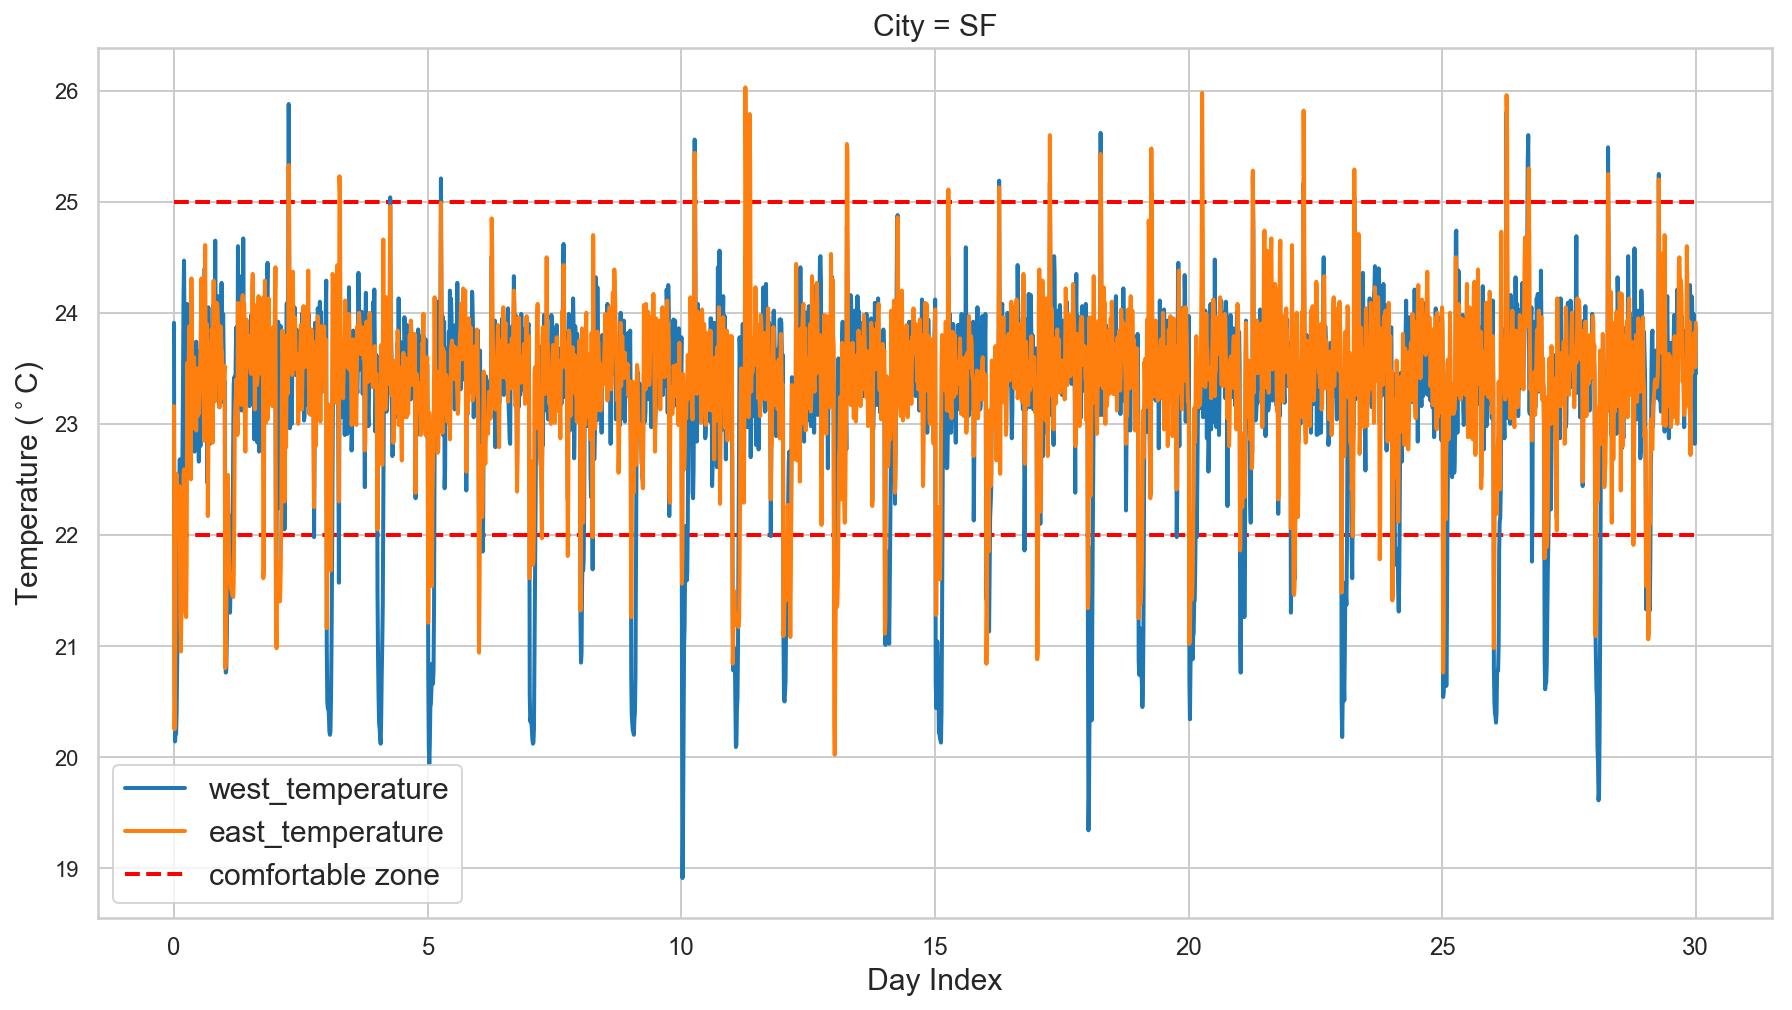

In [21]:
data_frame = pd.read_csv(get_log_dir('SF', 5, 10, 100) + '/episode-1.csv')
plot_temperature(data_frame, city='SF', start_index=90)

### Baseline vs. PPO vs. Model-based on violations and PUE

In [22]:
metric = 'Approach'
def create_approach_comparison_data_frame():
    policy = ['PID', 'Model-based', 'PPO']
    result = {'Approach':[], 'City': [], 'Daily PUE': [], 'Daily Violation Rate': [], 'Daily Average Power (MW)': []}
    for city in cities:
        # baseline
        data_frame = baseline_data_frame[city]
        pue = calculate_daily_pue(data_frame)
        violation_rate = calculate_daily_violation_rate(data_frame)
        result['Approach'].extend(['PID'] * pue.shape[0])
        result['City'].extend([city] * pue.shape[0])
        result['Daily PUE'].extend(pue.tolist())
        result['Daily Violation Rate'].extend(violation_rate.tolist())
        daily_average_power = calculate_daily_mean_total_power(data_frame)
        result['Daily Average Power (MW)'].extend(daily_average_power.tolist())

        # PPO
        data_frame = ppo_data_frame[city]
        pue = calculate_daily_pue(data_frame)
        violation_rate = calculate_daily_violation_rate(data_frame)
        result['Approach'].extend(['PPO'] * pue.shape[0])
        result['City'].extend([city] * pue.shape[0])
        result['Daily PUE'].extend(pue.tolist())
        result['Daily Violation Rate'].extend(violation_rate.tolist())
        daily_average_power = calculate_daily_mean_total_power(data_frame)
        result['Daily Average Power (MW)'].extend(daily_average_power.tolist())

        # model-based
        data_frame = pd.read_csv(get_log_dir(city, 5, 10, 120) + '/episode-1.csv')
        pue = calculate_daily_pue(data_frame)
        violation_rate = calculate_daily_violation_rate(data_frame)
        result['Approach'].extend(['Model-based'] * pue.shape[0])
        result['City'].extend([city] * pue.shape[0])
        result['Daily PUE'].extend(pue.tolist())
        result['Daily Violation Rate'].extend(violation_rate.tolist())
        daily_average_power = calculate_daily_mean_total_power(data_frame)
        result['Daily Average Power (MW)'].extend(daily_average_power.tolist())
        
    result = pd.DataFrame(result)
    return result

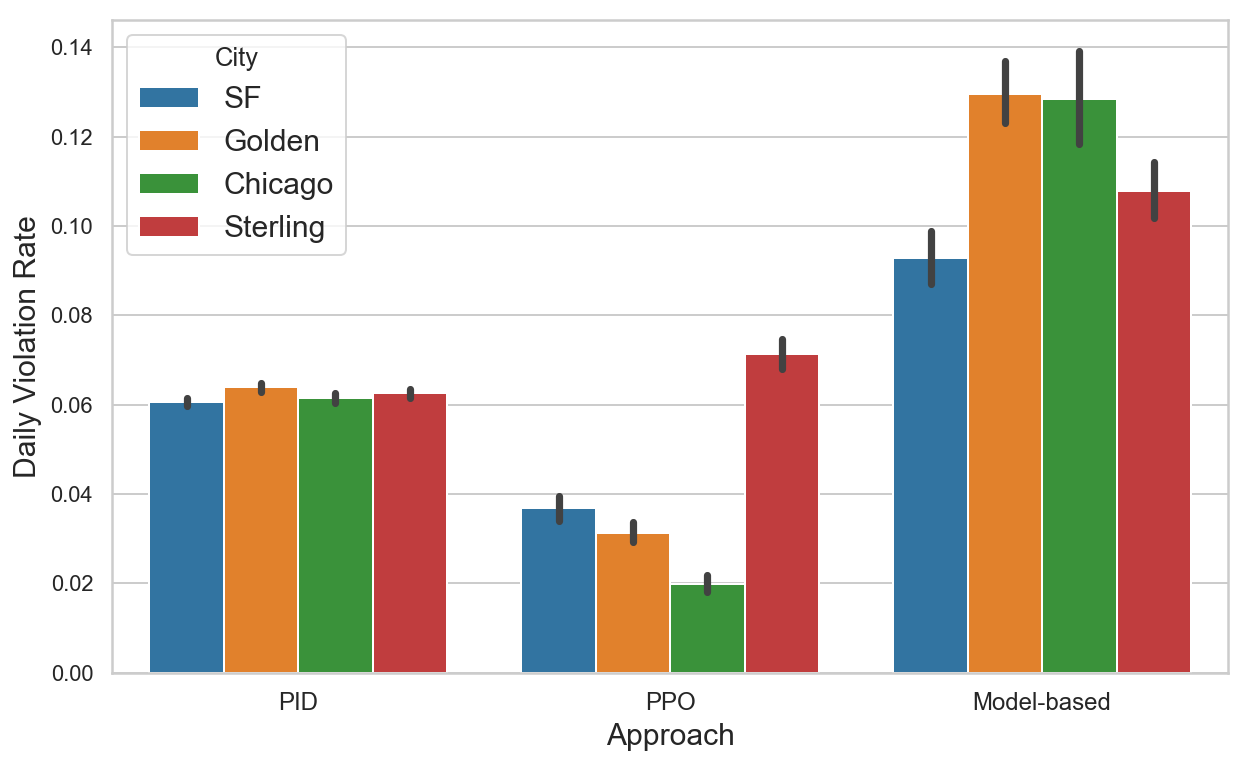

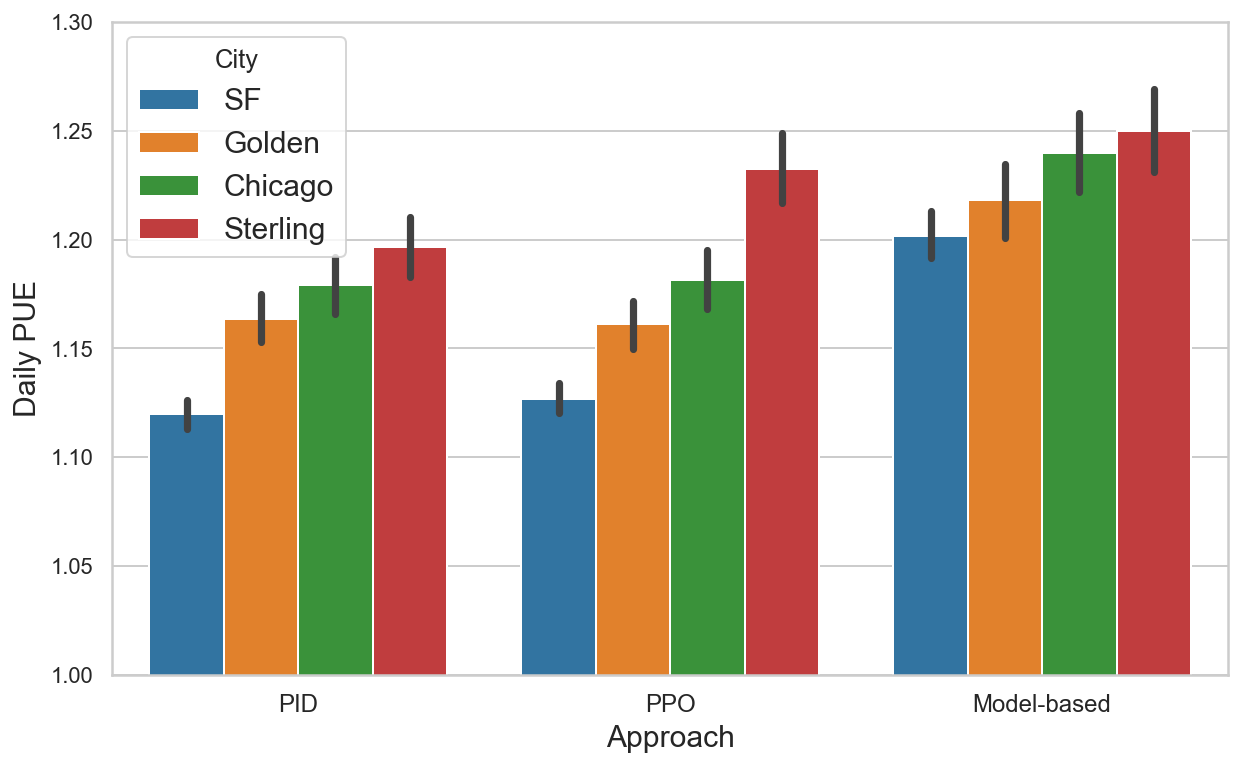

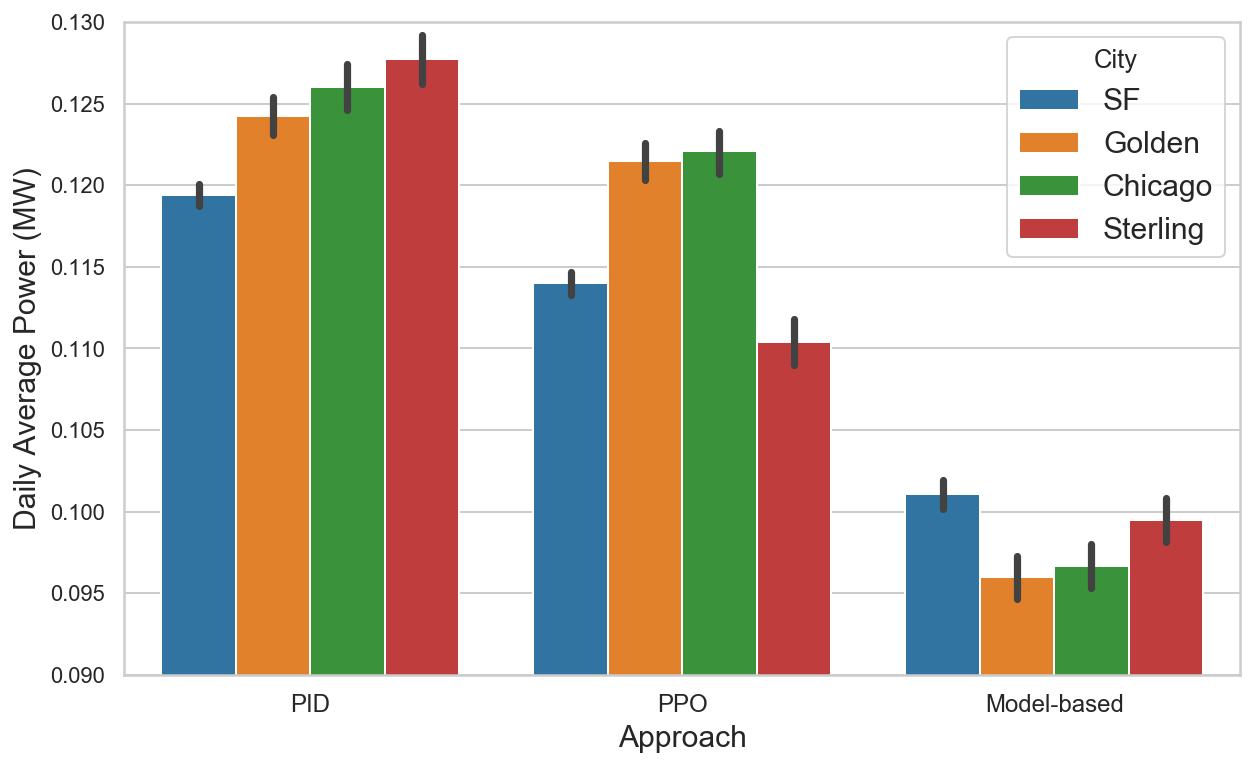

In [25]:
approach_comparison_data_frame = create_approach_comparison_data_frame()
ax = sns.barplot(x=metric, y="Daily Violation Rate", hue="City", data=approach_comparison_data_frame)
plt.show()
ax = sns.barplot(x=metric, y="Daily PUE", hue="City", data=approach_comparison_data_frame)
ax.set_ylim(1.0, 1.3)
plt.show()
ax = sns.barplot(x=metric, y="Daily Average Power (MW)", hue="City", data=approach_comparison_data_frame)
ax.set_ylim(0.09, 0.13)
plt.show()

### Performance vs Training Iterations

In [26]:
model_based_train_stats = pd.read_csv('data/model_based.csv')
ppo_train_stats = pd.read_csv('data/ppo.csv')

Text(0, 0.5, 'Reward')

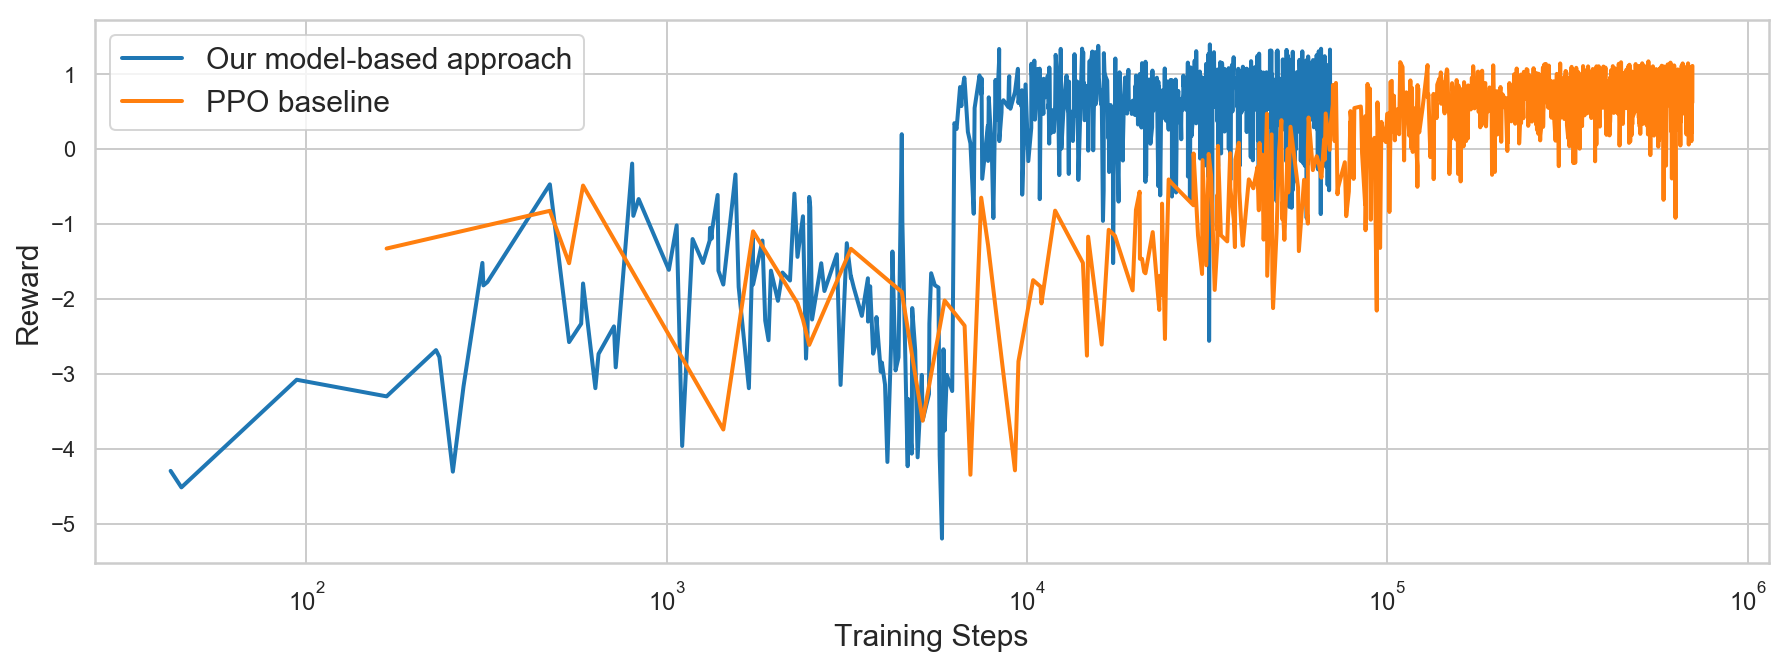

In [27]:
plt.figure(figsize=(15, 5))
plt.semilogx(model_based_train_stats['Step'], model_based_train_stats['Value'], label='Our model-based approach')
plt.semilogx(ppo_train_stats['Step'], ppo_train_stats['Value'], label='PPO baseline')
plt.legend()
plt.xlabel('Training Steps')
plt.ylabel('Reward')